In [1]:
import os, time, shutil
from pathlib import Path
import numpy as np
import spikeinterface.full as si

/home/phornauer/miniconda3/envs/elephant/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sorting for recording at: /cluster/project/bsse_sdsc/BELUB/Measurements/Cell_line_9/200217/5206/Network/

In [2]:
input_path = '/net/bs-filesvr02/export/group/hierlemann/recordings/Mea1k/phornauer/DeePhys/'
save_path = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Mea1k/phornauer/si_test/'
rec_date = '220628'
chip_id = 'M04256'
run_id = '000063'
file_name = "recording.raw.h5"
#rec_path = os.path.join(input_path, rec_date, chip_id, 'Network', )
rec_path = os.path.join(input_path, file_name)
assert (os.path.exists(rec_path))

In [3]:
si.get_default_sorter_params(si.si_based_sorters.Spykingcircus2Sorter)

{'general': {'ms_before': 2.5, 'ms_after': 3.5, 'local_radius_um': 100},
 'waveforms': {'max_spikes_per_unit': 200, 'overwrite': True},
 'filtering': {'freq_min': 300, 'dtype': 'float32'},
 'detection': {'peak_sign': 'neg', 'detect_threshold': 5},
 'selection': {'n_peaks_per_channel': 5000, 'min_n_peaks': 20000},
 'localization': {},
 'clustering': {},
 'matching': {},
 'registration': {},
 'common_reference': True,
 'job_kwargs': {'n_jobs': -1, 'chunk_duration': '1s', 'verbose': False}}

In [20]:
si.get_default_sorter_params(si.si_based_sorters.Tridesclous2Sorter)

{'apply_preprocessing': True,
 'general': {'ms_before': 2.5, 'ms_after': 3.5, 'local_radius_um': 100},
 'filtering': {'freq_min': 300, 'freq_max': 8000.0},
 'detection': {'peak_sign': 'neg',
  'detect_threshold': 5,
  'exclude_sweep_ms': 0.4},
 'hdbscan_kwargs': {'min_cluster_size': 25,
  'allow_single_cluster': True,
  'core_dist_n_jobs': -1,
  'cluster_selection_method': 'leaf'},
 'waveforms': {'max_spikes_per_unit': 300},
 'selection': {'n_peaks_per_channel': 5000, 'min_n_peaks': 20000},
 'localization': {'max_distance_um': 1000,
  'optimizer': 'minimize_with_log_penality'},
 'matching': {'peak_shift_ms': 0.2},
 'job_kwargs': {'n_jobs': -1, 'chunk_duration': '1s', 'progress_bar': True}}

In [3]:
si.get_default_sorter_params(si.Kilosort2Sorter)

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'wave_length': 61,
 'keep_good_only': False,
 'n_jobs': 1,
 'total_memory': None,
 'chunk_size': None,
 'chunk_memory': None,
 'chunk_duration': '1s',
 'progress_bar': True}

si.Kilosort2Sorter.set_kilosort2_path('/home/phornauer/Spikesorters/Kilosort-2.0/')
sorter = 'kilosort2'

### sorter params - only params of the sorter used ###
sorter_params = si.get_default_sorter_params(si.si_based_sorters.Spykingcircus2Sorter)#{"n_jobs_bin": 8, "total_memory": "8G", "NT": 8*1024+64}
sorter_params['job_kwargs']['n_jobs'] = 16
sorter_params['job_kwargs']['chunk_duration'] = '10s'

In [7]:
si.Kilosort2Sorter.set_kilosort2_path('/home/phornauer/Git/Kilosort2/')
sorter = 'kilosort2'
sorter_params = si.get_default_sorter_params(si.Kilosort2Sorter)
sorter_params['n_jobs'] = 16

Setting KILOSORT2_PATH environment variable for subprocess calls to: /home/phornauer/Git/Kilosort2


In [8]:
### Set parameters ###
# If true, and spike sorting output is present, it's deleted and resorted
recompute_sorting = False
recompute_curation = False
# If true, filtered data and sorted outputs are saved in a format that it's easy to retrieve (.pkl)
dump_recording = True
dump_sorting = True
# If true, exports to Phy
export_raw_to_phy = False
export_curated_to_phy = True
# If true, unit templates are plotted for all units
plot_unit_templates = True
plot_image = True
### Filter params ###
freq_min = 300
freq_max = 5000
### Automatic curation ###
# If true, output is automatically curated using quality metrics (QC)
auto_curate = True
# Thresholds for automatic curations (if any is None, that autocuration is skipped
# ISI-violation ratio (greater values are removed)
isi_viol_thresh = 0.5
# firing rate (smaller values are removed)
fr_thresh = 0.05
# signal-to-noise ratio (smaller values are removed)
snr_thresh = 5
### Other processing params - used for all sorters ###
# number of jobs to use
n_jobs = 16
# total RAM to use
total_memory = "5000M"
# chunk size
chunk_size = 10000
# Number of spikes per unit to compute templates (None-> all spikes are used)
max_spikes_per_unit = None
# Number of channels to compute center of mass
num_channels_for_com = 30

In [10]:
output_folder = Path(os.path.join(save_path, 'sorted'))
cache_folder = Path(os.path.join(save_path, 'cache'))
figures_folder = Path(os.path.join(save_path, 'figures'))
output_folder.mkdir(parents=True, exist_ok=True)
cache_folder.mkdir(parents=True, exist_ok=True)
figures_folder.mkdir(parents=True, exist_ok=True)
tmp_folder = cache_folder / 'tmp' / sorter
tmp_folder.mkdir(parents=True, exist_ok=True)
# Load recording
try:
    print("Trying to load Maxwell recording")
    rec = si.MaxwellRecordingExtractor(rec_path)
except:
    raise Exception(f"Could not open the provided file: {rec_path} with the MaxwellRecordingExtractor")

print(f"DURATION: {rec.get_num_frames() / rec.get_sampling_frequency()} s -- "
      f"NUM. CHANNELS: {rec.get_num_channels()}")
print(rec.get_sampling_frequency())

### Filter and dumping
if (cache_folder / 'recording').is_dir():
    print("Loading saved recording")
    rec_cache = si.load_extractor(cache_folder / 'recording')
else:
    print('FILTERING\n')
    rec_f = si.bandpass_filter(rec, freq_min=freq_min, freq_max=freq_max)

    if dump_recording:
        start = time.time()
        rec_cache = rec_f.save(folder=cache_folder / "recording", n_jobs=n_jobs, chunk_size=chunk_size,
                               progress_bar=True)
        stop = time.time()
        print(f'Elapsed saving time {np.round(stop - start, 2)}\n')
        print(f"Filtered recording saved to {cache_folder / 'recording'}\n")
    else:
        rec_cache = rec_f
fs = rec_cache.get_sampling_frequency()

### Spike sorting
if recompute_sorting and output_folder.is_dir():
    shutil.rmtree(output_folder)
try:
    if not (cache_folder / 'sorting_raw').is_dir():
        print(f'SORTING WITH {sorter}\n')
        t_start_sort = time.time()
        sorting = si.run_sorter(sorter, rec_cache, output_folder=output_folder, verbose=True,
                                **sorter_params)
        print(f"\n\nSpike sorting elapsed time {time.time() - t_start_sort} s")
    else:
        print('Skipping', rec_path, ' since already sorted')
        sorting = si.load_extractor(cache_folder / 'sorting_raw')
except Exception as e:
    print(f"{sorter} failed on recording {rec_path}\n\nError: {e}")

if export_raw_to_phy and not (cache_folder / "phy_raw").is_dir():
    we_raw = si.extract_waveforms(rec_cache, sorting, folder=cache_folder / "waveforms_raw", load_if_exists=True,
                                  n_jobs=n_jobs, total_memory=total_memory, progress_bar=True)
    print("Exporting raw sorting output to Phy")
    si.export_to_phy(we_raw, cache_folder / "phy_raw", n_jobs=n_jobs, total_memory=total_memory,
                     progress_bar=True)

Trying to load Maxwell recording
DURATION: 900.55 s -- NUM. CHANNELS: 1020
20000.0
Loading saved recording
SORTING WITH kilosort2

RUNNING SHELL SCRIPT: /tmp/tmp_shellscript816yrqs2/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptyo1ksmip/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptkgo1b_jr/script.sh
RUNNING SHELL SCRIPT: /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Mea1k/phornauer/si_test/sorted/run_kilosort2.sh


                            < M A T L A B (R) >

                  Copyright 1984-2021 The MathWorks, Inc.

                  R2021a (9.10.0.1602886) 64-bit (glnxa64)

                             February 17, 2021



 

To get started, type doc.

For product information, visit www.mathworks.com.

 

Time   2s. Determining good channels.. 

found 1454265 threshold crossings in 301.76 seconds of data 

found 5 bad channels 

Time 289s. Computing whitening matrix.. 

Getting channel whitening matrix... 

Channel-whitening matrix computed. 

Time 322s

In [ ]:
we_raw = si.extract_waveforms(rec_cache, sorting, folder=cache_folder / "waveforms_raw", load_if_exists=True,
                              n_jobs=n_jobs, total_memory=total_memory, progress_bar=True)
print("Exporting raw sorting output to Phy")
si.export_to_phy(we_raw, cache_folder / "phy_raw", n_jobs=n_jobs, total_memory=total_memory,
                 progress_bar=True)

extract waveforms memmap:  60%|████████████████████████████████████████████████████████████▏                                       | 71/118 [2:11:14<1:26:52, 110.91s/it]


In [11]:
export_raw_to_phy and not (cache_folder / "phy_raw").is_dir()

False

In [18]:
snippet = rec_cache.get_traces(segment_index=None,start_frame=0,end_frame=20000)

In [13]:
output_folder = Path(os.path.join(save_path, 'sorted'))
cache_folder = Path(os.path.join(save_path, 'cache'))
figures_folder = Path(os.path.join(save_path, 'figures'))
rec_cache = si.load_extractor(cache_folder / 'recording')


In [16]:
rec_cache.is_filtered()

True

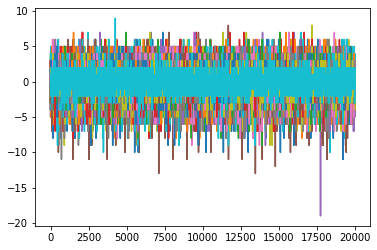

In [19]:
plt.plot(snippet);